# Introduction to Machine learning

In [1]:
using Flux #used to defined the neural network

**Example of a neural network** The neural network must be a function which is provide with a value and output the constant value of 1. Here is the neural network with 10 inputs, then the first hidden layer has 32 neurons and activation function $\tanh{x}$, the second hidden layer has 32 neurons with the same activation function, and the last layer, has 5 outputs. Think of it as an input vector with 10 entries and an output vector with 5 entries.

In [2]:
# definig the neural networ
NN = Chain(
    Dense(10, 32, tanh),
    Dense(32, 32, tanh),
    Dense(32, 5)
)

# checking the neural network without training
NN(rand(10))

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(10 => 32, tanh)
│   summary(x) = 10-element Vector{Float64}
└ @ Flux /Users/joseignacioperdiguerogarate/.julia/packages/Flux/Wz6D4/src/layers/stateless.jl:60


5-element Vector{Float32}:
  0.85705626
 -0.21515632
  0.30127093
 -0.08375928
 -0.13824788

In [3]:
# defining the loss function
loss() =  sum(abs2, sum(abs2, NN(rand(10)).-1) for i in 1:100)
loss()

3191.5022f0

In [4]:
# you can inspect the values of the weights
NN[1].weight
NN[2].weight
NN[3].weight

5×32 Matrix{Float32}:
  0.226891    -0.307487  -0.0708107  …   0.0245622  -0.369213    0.0146982
 -0.00852138   0.343894  -0.0604057     -0.0931236  -0.332008    0.210401
  0.205699    -0.296582  -0.271192       0.309691   -0.0764354  -0.292662
 -0.36208     -0.202579   0.109487       0.331656    0.268871   -0.178498
 -0.12273      0.30458    0.226695      -0.111288   -0.342124    0.00574555

In [5]:
# collect the parameters and set the train
p = Flux.params(NN)
Flux.train!(loss, p, Iterators.repeated((), 10000), ADAM(0.1))
loss()

1.1049849f-5

In [6]:
# checking the neural network after the training
NN(rand(10))

5-element Vector{Float32}:
 0.99938416
 1.0045608
 0.99137986
 1.0091134
 1.0030311

The idea of using machine learning, is that there is a function which can described your data-information, this is known as the inference problem. Because of this, it is extremely convenient to use neural networks to find an approximation of this function, and there are two major reasons to use neural networks: the universal approximation theorem and the solution of the curse of dimensionality problem.

The idea is that we can use neural network to solve differential equations, and the field is known as physics informed neural network or pinns. This is done by, defining the loss function, and introducing the physical initial/boundary condition to the loss functions, this does not forced the initial conditions on the $NN(x)$. Then you minimized the loss function, and thus, solving the differential equation. There are other ways on which you can force the initial/boundary conditions by building a new function using the $NN(x)$ as a base plus the intial conditions. Let's see an example of the second method and solve this differential equation $u' = \cos (2\pi t)$ where $u(0) = 1$

In [7]:
# defines a neural network ODE which takes a scalar as a inpun and transforms it into an array, and produces a scalar x -> x[1]
NNOde = Chain(x -> [x],
        Dense(1, 32, tanh),
        Dense(32, 1),
        first)
NNOde(1.0)

-0.07230156f0

In [8]:
# define the universal approximation function and force the initial conditions
g(t) = t*NNOde(t) + 1f0

g (generic function with 1 method)

In [9]:
using Statistics #used to define the derivative by finite methods

In [10]:
# definig the loss function as the equation that universal approximation function must satisfy from t between 0 and 1
ϵ = sqrt(eps(Float32))
loss() = mean(abs2((g(t + ϵ) - g(t))/ϵ - cos(2*π*t)) for t in 0:1f-2:1f0)

loss (generic function with 1 method)

In [11]:
# training the network
opt = Flux.Descent(0.01)
data = Iterators.repeated((), 5000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(loss())
  end
end
display(loss())

Flux.train!(loss, Flux.params(NNOde), data, opt; cb=cb)

0.5080362035279166

0.4902884438807584

0.45431094068742234

0.3314928478059543

0.11654512230448315

0.028713563166010068

0.016361523773902483

0.012675642494657089

0.01117090564349212

0.010494446727383

0.010101566072550592

In [12]:
using Plots #used to plot function

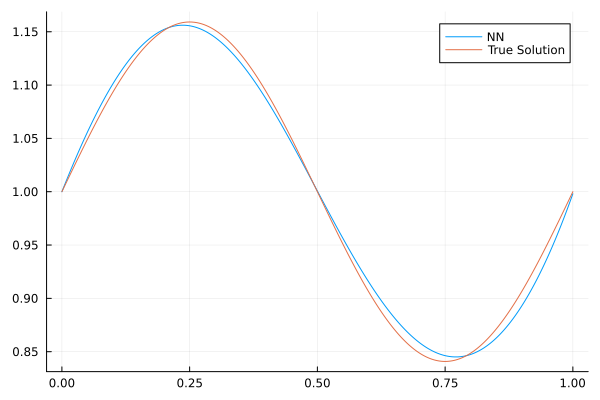

In [13]:
# ploting the neural network solution vs the real solution
t = 0:0.001:1.0
plot(t,g.(t),label="NN")
plot!(t,1.0 .+ sin.(2π.*t)/2π, label = "True Solution")

Let's see the forced harmonic oscillator subject to an external force like $F(x) = =k*x + 0.1 \sin (x)$. Assuming the mass of the oscillator to be equal to 1, meaning that $ m = 1$ and $k = 1$, then the second order differential equations is $x'' = -k*x + 0.1\sin (x)$

In [14]:
using DifferentialEquations #used to solved differential equations

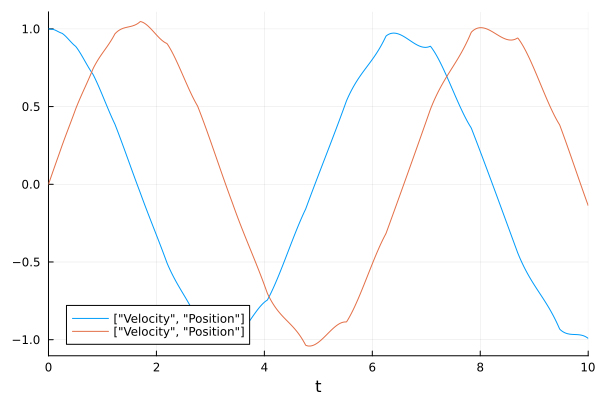

In [19]:
# parameters of the problem
m = 1;
k = 1;
force(dx, x, k, t) = -k*x + 0.1*sin(x)
# intial conditions: velocity and position, tspan from 0 to 10
prob = SecondOrderODEProblem(force, 1.0, 0.0, (0.0, 10.0), k)
sol = solve(prob)
plot(sol, label = ["Velocity", "Position"])

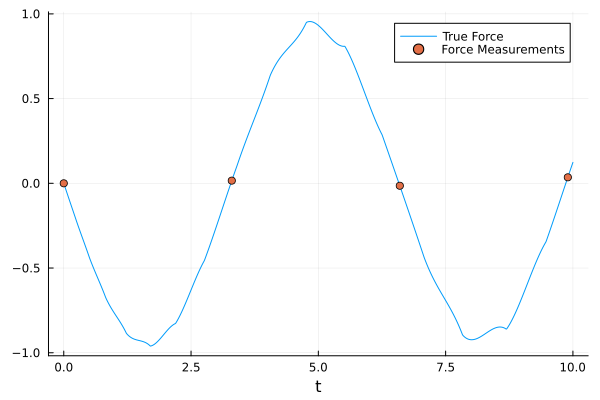

In [20]:
# lets predict the force applied on the spring at each point F(x)
plot_t = 0:0.01:10
data_plot = sol(plot_t)
positions_plot = [state[2] for state in data_plot]
force_plot = [force(state[1],state[2],k,t) for state in data_plot]

# Generate the dataset
t = 0:3.3:10
dataset = sol(t)
position_data = [state[2] for state in sol(t)]
force_data = [force(state[1],state[2],k,t) for state in sol(t)]

plot(plot_t,force_plot,xlabel="t",label="True Force")
scatter!(t,force_data,label="Force Measurements")

In [21]:
# defines the neural network
NNForce = Chain(x -> [x],
        Dense(1 => 32,tanh),
        Dense(32 => 1),
        first)

Chain(
  var"#25#26"(),
  Dense(1 => 32, tanh),                 # 64 parameters
  Dense(32 => 1),                       # 33 parameters
  first,
)                   # Total: 4 arrays, 97 parameters, 644 bytes.

In [22]:
# defines the loss function
loss() = sum(abs2,NNForce(position_data[i]) - force_data[i] for i in 1:length(position_data))
loss()

0.0038291104958369983

In [23]:
# train the neural network
opt = Flux.Descent(0.01)
data = Iterators.repeated((), 5000)
iter = 0
cb = function () #callback function to observe training
    global iter += 1
    if iter % 500 == 0
    display(loss())
    end
end
display(loss())
Flux.train!(loss, Flux.params(NNForce), data, opt; cb=cb)

0.0038291104958369983

0.0026462297679155015

0.0022784343940502267

0.001963124084733021

0.0016921968405742122

0.0014590004621827819

0.0012580210486773731

0.0010846477888065377

0.000935001268646677

0.000805785907234899

0.0006941990469198716

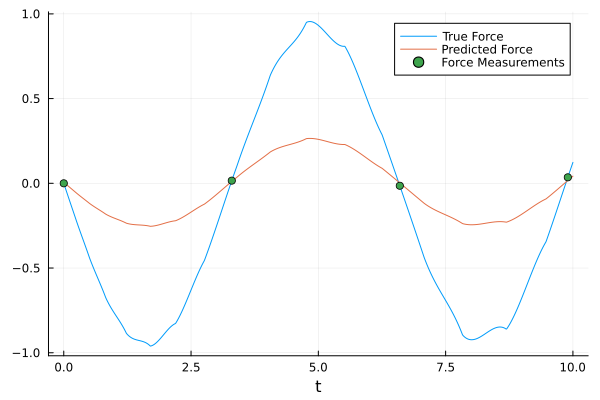

In [24]:
# ploting the trained neural network
learned_force_plot = NNForce.(positions_plot)

plot(plot_t,force_plot,xlabel="t",label="True Force")
plot!(plot_t,learned_force_plot,label="Predicted Force")
scatter!(t,force_data,label="Force Measurements")

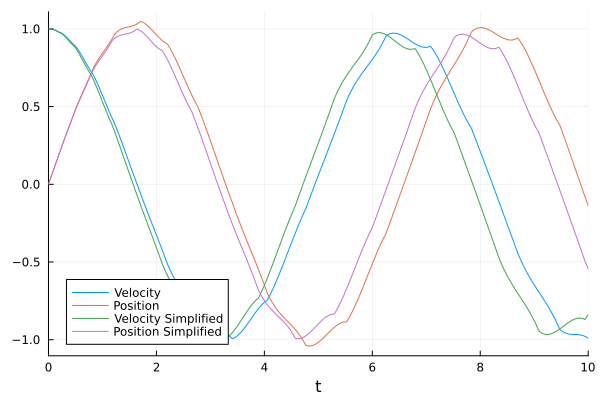

In [25]:
# we need more data to improve the performance
force2(dx,x,k,t) = -k*x
prob_simplified = SecondOrderODEProblem(force2,1.0,0.0,(0.0,10.0),k)
sol_simplified = solve(prob_simplified)
plot(sol,label=["Velocity" "Position"])
plot!(sol_simplified,label=["Velocity Simplified" "Position Simplified"])

In [27]:
#  new loss function
random_positions = [2rand()-1 for i in 1:100] # random values in [-1,1]
loss_ode() = sum(abs2,NNForce(x) - (-k*x) for x in random_positions)
loss_ode()

# total loss function
λ = 0.1
composed_loss() = loss() + λ*loss_ode()

composed_loss (generic function with 1 method)

In [29]:
# training the neural network
opt = Flux.Descent(0.01)
data = Iterators.repeated((), 5000)
iter = 0
cb = function () #callback function to observe training
    global iter += 1
    if iter % 500 == 0
        display(composed_loss())
    end
end
display(composed_loss())
Flux.train!(composed_loss, Flux.params(NNForce), data, opt; cb=cb)

0.00032886821196354785

0.0003164960456863249

0.000304905117089437

0.00029402936385013986

0.00028380015882351197

0.00027416380782658146

0.00026507219288943786

0.0002564795979793416

0.0002483447090725091

0.00024063147544802377

0.0002333126239654863

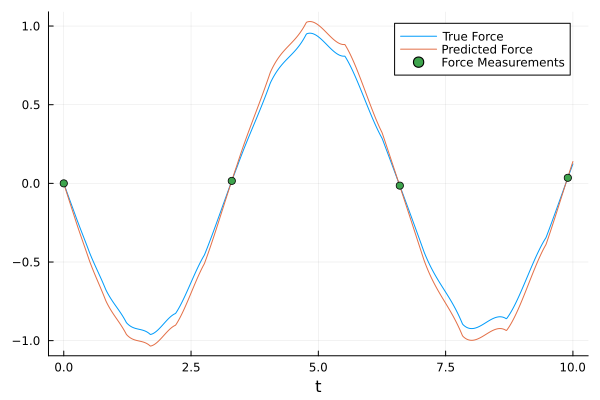

In [30]:
# ploting the results
learned_force_plot = NNForce.(positions_plot)

plot(plot_t,force_plot,xlabel="t",label="True Force")
plot!(plot_t,learned_force_plot,label="Predicted Force")
scatter!(t,force_data,label="Force Measurements")